# Reconstruction of the directional wave spectrum using IOWAGA 


In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Jonswap spectrum and directional distribution

In [3]:
# jonswap spectrum
def jonswap(frqs, Hs, Tp, gamma=3.3):
    """Returns the JONSWAP spectrum for a given Hs, Tp and frequency array"""
    
    # constants
    fp = 1./Tp
    alpha, beta, g = 8.1E-3, 5./4., 9.8
    
    # it could be vectorized!
    S = np.zeros_like(frqs)
    for i, f in enumerate(frqs):
        if f == 0.:
            S[i] = 0.
        else:
            num = alpha * (g**2)
            den = ((2*np.pi)**4) * f**5
            pm = (num / den) * np.exp(-beta * (fp/f)**4)
            sigma = 0.07 if f <= fp else 0.09
            r = np.exp(-(f - fp)**2 / (2.*(sigma**2)*(fp**2)))
            S[i] = pm * gamma**r
    
    # scale spectrum with zero-order moment 
    m0 = np.trapz(S, x=frqs)
    return (S / m0) * (Hs**2 /16)

In [4]:
# directional wave spectrum 
def directional_wave_spectrum(frqs, dirs, Hs, Tp, mdir, func="cos2s", s=1):
    """Returns the directional wave spectrum"""
     
    # frequency spectrum from jonswap
    S = jonswap(frqs, Hs=Hs, Tp=Tp, gamma=3.3)

    # direction arrays
    dir2 = (dirs - mdir) % 360
    dir3 = dirs - 180

    # cos2s
    if func == "cos2s":
        #
        D = (2. / np.pi) * np.cos((dirs - mdir)*np.pi/180.)**(2*s)
        D[np.logical_and(dir2>90, dir2<270)] = 0.
        E = S[None,:] * D[:,None]
        
    # sech2
    if func == "sech2":
        #
        ffp = frqs*Tp
        beta = np.ones(len(frqs))*1.24
        beta[np.logical_and(ffp>=0.56, ffp<0.95)] = 2.61 * ffp[np.logical_and(ffp>=0.56, ffp<0.95)]**(1.3)
        beta[np.logical_and(ffp>=0.95, ffp<1.60)] = 2.28 * ffp[np.logical_and(ffp>=0.95, ffp<1.60)]**(-1.3)
        E = S[None,:] * (beta[None,:] / 2) * np.cosh(beta[None,:] * (dir3[:,None])*np.pi/180.)**(-2)
        #
        ixd = np.argsort(((dir3 + mdir) % 360))
        E = E[ixd,:]
    
    # scale spectrum with zero-order moment 
    m0 = np.abs(np.trapz(np.trapz(E, x=np.radians(dirs), axis=0), x=frqs))
    return (E / m0) * (Hs**2 / 16)

## Nice representation of the spectrum

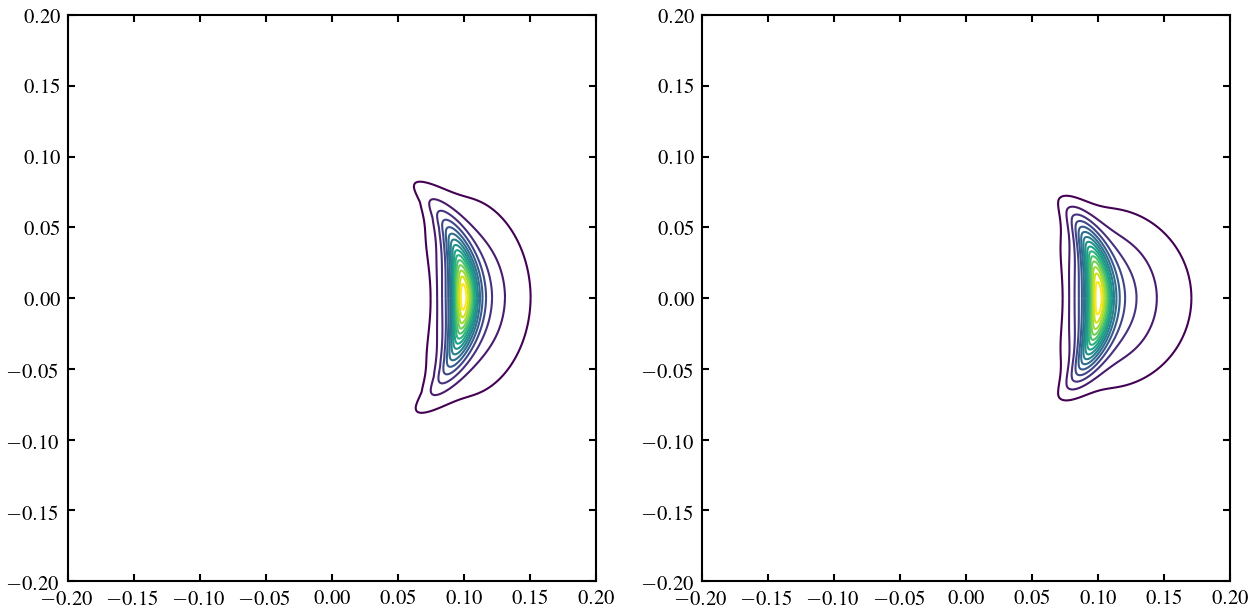

In [27]:
frqs = np.linspace(0,.2,1000)
dirs = np.arange(361)
Hs, Tp, mdir = 1, 10, 0
E1 = directional_wave_spectrum(frqs, dirs, Hs, Tp, mdir, func="sech2")
E2 = directional_wave_spectrum(frqs, dirs, Hs, Tp, mdir, func="cos2s", s=4)

Fx = frqs[None,:] * np.cos(dirs[:,None]*np.pi/180)
Fy = frqs[None,:] * np.sin(dirs[:,None]*np.pi/180)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5), dpi=150)
ax1.contour(Fx, Fy, E1, 20)
ax2.contour(Fx, Fy, E2, 20)

## Retrieving the data from the web

In [ ]:
# download file from ifremer ftp server
def download_from_ftp(filename):
    """Copy file from FTP to local directory"""

    local_path = "/Volumes/Boyas/iowaga/"
    
    with ftplib.FTP("ftp.ifremer.fr") as ftp:
        
        # login the ftp
        ftp.login()
        ftp.cwd("ifremer/ww3/HINDCAST/")

        # create local folder if it does not exist
        folder = os.path.join(local_path, os.path.split(filename)[0])
        if not os.path.exists(folder):
            os.makedirs(folder)
        
        print(f"Downloading from FTP: {filename}")
        with open(os.path.join(local_path, filename), "wb") as f:
            cmd = f"RETR {filename}"
            try:
                ftp.retrbinary(cmd, f.write)
                return True
            except:
                print("File couldn't be downloaded")
                return False


In [ ]:
# load dataset
def load_dataset(year, month, region="GLOBAL", wind_source="ECMWF"):
    """Returns all the netcdf datasets por the specific region"""

    local_path = "/Volumes/Boyas/iowaga/"
    basename = f"{region}/{year}_{wind_source}/partitions"

    if region == "GLOBAL":
        grid = "30M"
        rcode = "GLOB"
    else:
        grid = "10M"

    dic = {}
    list_of_variables = ["phs", "pdir", "ptp"]
    for variable in list_of_variables:
        for partition in range(6):
            
            # create filename
            parameter = f"{variable}{partition}"
            filename = f"{basename}/WW3-{rcode}-{grid}_{year}{month:02d}_{parameter}.nc"
            
            # check if local filename exist
            local_filename = os.path.join(local_path, filename)
            if os.path.exists(local_filename):
                dataset = nc.Dataset(local_filename, "r")
            #
            # if not, download it from ftp server
            else:
                result = download_from_ftp(filename)
                if result:
                    dataset = nc.Dataset(local_filename, "r")

            # store in a dictionary
            dic[parameter] = dataset

    return dic

In [ ]:
# extract data in a specific point
def extract_point(dic, date, lon=-96.6245, lat=24.6028):
    """Extract the partition parameters in a specific point"""

    results = {}
    for parameter, dataset in dic.items():
        
        # choose the interest variables
        time = nc.num2date(dataset["time"][:].data, dataset["time"].units)
        glat = dataset["latitude"][:]
        glon = dataset["longitude"][:]
        
        # find the indices of the specific pont
        ixtime = np.argmin(abs(time - date))
        ixlat = np.argmin(abs(glat - lat))
        ixlon = np.argmin(abs(glon - lon))

        # load the variables in a pont
        value = np.float32(dataset[parameter][ixtime, ixlat, ixlon])
        results[parameter] = value

    # save lon, lat and time
    results["lon"] = glon[ixlon]
    results["lat"] = glat[ixlat]
    results["time"] = time[ixtime]

    return results